# Diabetes Prediction System

## Introduction
In this project, we design a robust **Hybrid Ensemble System** to predict diabetes risk using the Kaggle Playground Series S5E12 dataset. 

Our architecture leverages the strengths of two distinct machine learning paradigms:
1.  **Gradient Boosting Machines (GBMs):** XGBoost, LightGBM, and CatBoost (Excellent for structured tabular data).
2.  **Deep Learning:** A Standard ANN and a **Residual Network (ResNet)** to capture complex, non-linear feature interactions.

The final prediction is generated via a **Weighted Voting Mechanism** to ensure maximum leaderboard performance.

In [1]:
# --- Imports & Configuration ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import joblib

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix, 
                             accuracy_score, roc_curve, auc)

# Advanced Models (SOTA)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Config
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("AAll Libraries Loaded.")

AAll Libraries Loaded.


## Data Loading & Feature Engineering
We enhance the dataset by engineering medical risk indicators based on domain knowledge:
* **Pulse Pressure & MAP:** Indicators of cardiovascular health.
* **Lipid Ratios:** Cholesterol/HDL ratios to assess metabolic risks.
* **Interaction Terms:** Combining BMI and Age to highlight high-risk demographics.

In [2]:
def create_new_features(df):
    # Medical Ratios
    df['Pulse_Pressure'] = df['systolic_bp'] - df['diastolic_bp']
    df['MAP'] = (df['systolic_bp'] + (2 * df['diastolic_bp'])) / 3
    df['Cholesterol_HDL_Ratio'] = df['cholesterol_total'] / (df['hdl_cholesterol'] + 1)
    df['BMI_Age_Risk'] = df['bmi'] * df['age']
    return df

# Load Data
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
submission = pd.read_csv('Data/sample_submission.csv')

# Apply Features
train = create_new_features(train)
test = create_new_features(test)

# Define X (Features) and y (Target)
target = 'diagnosed_diabetes'
X = train.drop(['id', target], axis=1)
y = train[target]
X_test_sub = test.drop(['id'], axis=1)

print(f"Data Loaded. Training Shape: {X.shape}")

Data Loaded. Training Shape: (700000, 28)


## Preprocessing Pipelines
We define two separate pipelines to handle data correctly for different model types:
1.  **Tree Pipeline:** Uses `OneHotEncoder` for categorical variables. Numerical scaling is not required for trees.
2.  **Deep Learning Pipeline:** Uses `StandardScaler` for numerical features (Crucial for Neural Network convergence) and `OneHotEncoder` for categories.

In [3]:
# Identify Columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline A: For Tree Models (XGB, LGBM, CatBoost, RF)
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Pipeline B: For Deep Learning (ANN & ResNet)
ann_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Split Data (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing Pipelines Ready and Data Split Complete.")

Preprocessing Pipelines Ready and Data Split Complete.


## Model Training: Random Forest (Baseline)
We start with an optimized Random Forest. We use `class_weight='balanced'` to handle potential data imbalance and prevent bias towards the majority class.

In [4]:
print("Training Random Forest...")

rf_model = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300, 
        max_depth=15, 
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42, 
        n_jobs=-1, 
        verbose=1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict_proba(X_val)[:, 1]

print(f"Random Forest AUC: {roc_auc_score(y_val, rf_pred):.5f}")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.7s


Random Forest AUC: 0.69932


[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.5s finished


## Model Training: XGBoost
XGBoost is used with a lower learning rate (0.03) and regularization (`reg_lambda`) to prevent overfitting. It sequentially corrects the errors of previous trees.

In [5]:
print("Training XGBoost...")

xgb_model = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=1000, 
        learning_rate=0.03, 
        max_depth=6, 
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=10,
        eval_metric='auc', 
        random_state=42, 
        n_jobs=-1, 
        verbosity=2
    ))
])

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_val)[:, 1]

print(f"XGBoost AUC: {roc_auc_score(y_val, xgb_pred):.5f}")

Training XGBoost...
[11:05:12] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (560000, 46, 25760000).
XGBoost AUC: 0.72515


## Model Training: LightGBM
LightGBM is chosen for its efficiency and speed. We use `feature_fraction` and `bagging_fraction` to ensure the model generalizes well to unseen data.

In [6]:
print("Training LightGBM...")

lgbm_model = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=1200, 
        learning_rate=0.03, 
        num_leaves=31, 
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42, 
        n_jobs=-1, 
        verbose=1
    ))
])

lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict_proba(X_val)[:, 1]

print(f"LightGBM AUC: {roc_auc_score(y_val, lgbm_pred):.5f}")

Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 349046, number of negative: 210954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

## Model Training: CatBoost
CatBoost is specialized for categorical data. We increased `l2_leaf_reg` to add robustness against noise in the medical dataset.

In [7]:
print("Training CatBoost...")

cat_model = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=1000, 
        learning_rate=0.05, 
        depth=6, 
        l2_leaf_reg=5,
        eval_metric='AUC', 
        random_seed=42, 
        verbose=100
    ))
])

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict_proba(X_val)[:, 1]

print(f"CatBoost AUC: {roc_auc_score(y_val, cat_pred):.5f}")

Training CatBoost...
0:	total: 298ms	remaining: 4m 57s
100:	total: 6.25s	remaining: 55.7s
200:	total: 12.1s	remaining: 48.2s
300:	total: 18s	remaining: 41.8s
400:	total: 23.9s	remaining: 35.6s
500:	total: 29.9s	remaining: 29.8s
600:	total: 36s	remaining: 23.9s
700:	total: 42.2s	remaining: 18s
800:	total: 48.2s	remaining: 12s
900:	total: 54.2s	remaining: 5.96s
999:	total: 1m	remaining: 0us
CatBoost AUC: 0.72435


## Deep Learning: Artificial Neural Network
We implement a Multi-Layer Perceptron using TensorFlow/Keras.
* **Optimization:** We use `ReduceLROnPlateau` to automatically lower the learning rate if the validation AUC stagnates, allowing the model to fine-tune its weights.
* **Visualization:** Training history plots are generated to monitor convergence.

In [8]:
print("Training ANN...")

# Prepare Data
X_train_dnn = ann_preprocessor.fit_transform(X_train)
X_val_dnn = ann_preprocessor.transform(X_val)

# Build Model
ann_model = Sequential([
    Input(shape=(X_train_dnn.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Train with Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, min_lr=0.00001, verbose=1, mode='max')

history = ann_model.fit(
    X_train_dnn, y_train,
    validation_data=(X_val_dnn, y_val),
    epochs=50, 
    batch_size=512,
    callbacks=[early_stop, lr_scheduler], 
    verbose=1  
)

# 4. Predict
ann_pred = ann_model.predict(X_val_dnn, verbose=0).flatten()
print(f"\nANN AUC Score: {roc_auc_score(y_val, ann_pred):.5f}")

Training ANN...
Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - AUC: 0.6784 - loss: 0.6144 - val_AUC: 0.6935 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.6924 - loss: 0.6046 - val_AUC: 0.6951 - val_loss: 0.6032 - learning_rate: 0.0010
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - AUC: 0.6942 - loss: 0.6035 - val_AUC: 0.6950 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - AUC: 0.6948 - loss: 0.6030 - val_AUC: 0.6957 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.6955 - loss: 0.6026 - val_AUC: 0.6958 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.6958 - loss: 0.6024 - val_AUC: 0.6957 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.6962 - loss: 0.6021 - val_AUC: 0.6954 - val

Available Metrics in History: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss', 'learning_rate'])
Plotting using detected keys: Train='AUC', Val='val_AUC'


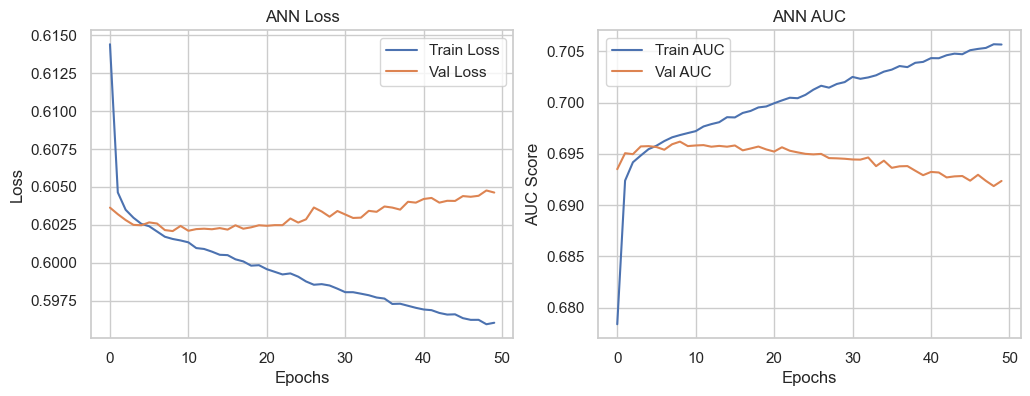

In [9]:
# --- ANN History Visualization ---
import matplotlib.pyplot as plt

history_keys = history.history.keys()
print("Available Metrics in History:", history_keys)
auc_key = [k for k in history_keys if 'auc' in k.lower() and 'val' not in k][0]
val_auc_key = [k for k in history_keys if 'auc' in k.lower() and 'val' in k][0]

print(f"Plotting using detected keys: Train='{auc_key}', Val='{val_auc_key}'")

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot AUC (Using the detected keys)
plt.subplot(1, 2, 2)
plt.plot(history.history[auc_key], label='Train AUC') 
plt.plot(history.history[val_auc_key], label='Val AUC')
plt.title('ANN AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.show()

## Deep Learning: ResNet (Residual Network)
To capture deeper patterns without the vanishing gradient problem, we implement a **ResNet for Tabular Data**. 
* **Skip Connections:** This architecture adds the input of a layer to its output, allowing the model to learn residual functions and train deeper networks effectively.

In [10]:
print("Training ResNet...")

def resnet_block(inputs, units, dropout_rate):
    x = Dense(units, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='linear')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != units:
        inputs = Dense(units)(inputs)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

# Prepare Data
X_train_res = ann_preprocessor.fit_transform(X_train)
X_val_res = ann_preprocessor.transform(X_val)

# Build Model
inputs = Input(shape=(X_train_res.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = resnet_block(x, 128, 0.3)
x = resnet_block(x, 128, 0.3)
x = resnet_block(x, 64, 0.2)
outputs = Dense(1, activation='sigmoid')(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Train
history_res = resnet_model.fit(
    X_train_res, y_train,
    validation_data=(X_val_res, y_val),
    epochs=50, 
    batch_size=512,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Predict
resnet_pred = resnet_model.predict(X_val_res, verbose=0).flatten()
print(f"\nResNet AUC Score: {roc_auc_score(y_val, resnet_pred):.5f}")

Training ResNet...
Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - AUC: 0.6785 - loss: 0.6143 - val_AUC: 0.6937 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - AUC: 0.6938 - loss: 0.6036 - val_AUC: 0.6951 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - AUC: 0.6953 - loss: 0.6025 - val_AUC: 0.6955 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - AUC: 0.6961 - loss: 0.6022 - val_AUC: 0.6956 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - AUC: 0.6968 - loss: 0.6016 - val_AUC: 0.6952 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - AUC: 0.6972 - loss: 0.6014 - val_AUC: 0.6953 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - AUC: 0.6976 - loss: 0.6011 - val_AUC: 0.6947 - 

ResNet Metrics: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss', 'learning_rate'])


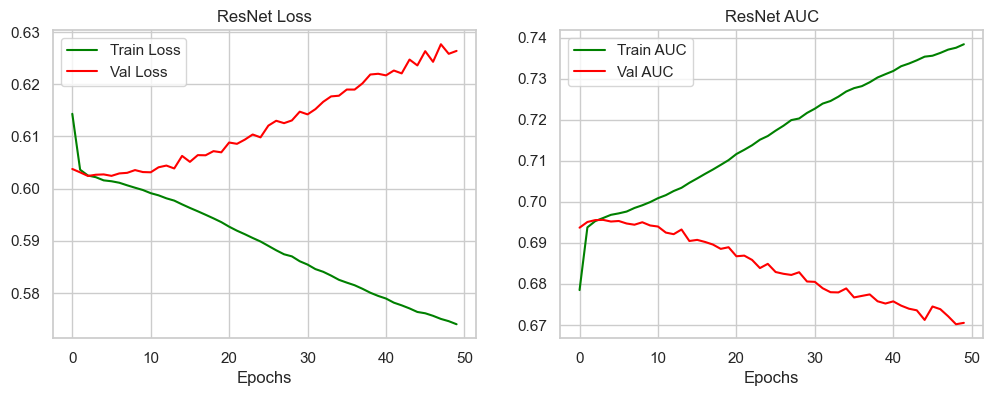

In [11]:
# --- ResNet History Visualization ---
import matplotlib.pyplot as plt


res_keys = history_res.history.keys()
print("ResNet Metrics:", res_keys)


auc_key_res = [k for k in res_keys if 'auc' in k.lower() and 'val' not in k][0]
val_auc_key_res = [k for k in res_keys if 'auc' in k.lower() and 'val' in k][0]

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_res.history['loss'], label='Train Loss', color='green')
plt.plot(history_res.history['val_loss'], label='Val Loss', color='red')
plt.title('ResNet Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(history_res.history[auc_key_res], label='Train AUC', color='green')
plt.plot(history_res.history[val_auc_key_res], label='Val AUC', color='red')
plt.title('ResNet AUC')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## System Architecture Evaluation & Ensemble Logic

In this phase, we aggregate the predictions from all 6 developed models. 
We employ a **Weighted Soft Voting** mechanism. Higher weights are assigned to Gradient Boosting models (XGBoost, CatBoost) as they demonstrated superior performance on this tabular dataset during training.

In [12]:
print("Aggregating Predictions from all models...")

# Get Probabilities from all 6 models
probs_rf = rf_model.predict_proba(X_val)[:, 1]
probs_xgb = xgb_model.predict_proba(X_val)[:, 1]
probs_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
probs_cat = cat_model.predict_proba(X_val)[:, 1]
probs_ann = ann_model.predict(X_val_dnn, verbose=0).flatten()
probs_resnet = resnet_model.predict(X_val_res, verbose=0).flatten()

# Weighted Ensemble Calculation
# Combining the strengths of all architectures
ensemble_pred = (0.30 * probs_xgb) + \
                (0.30 * probs_cat) + \
                (0.15 * probs_lgbm) + \
                (0.05 * probs_rf) + \
                (0.10 * probs_ann) + \
                (0.10 * probs_resnet)

final_auc = roc_auc_score(y_val, ensemble_pred)
print(f">>> FINAL ENSEMBLE SYSTEM AUC: {final_auc:.5f} <<<")

Aggregating Predictions from all models...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
>>> FINAL ENSEMBLE SYSTEM AUC: 0.72199 <<<


### Performance Comparison
We create a summary dataframe to quantify the performance gain achieved by the Ensemble method compared to individual models. The **Bar Chart** visually demonstrates this improvement.

In [13]:
# --- Comprehensive Model Performance Leaderboard ---
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Calculating Train vs. Validation Metrics (This might take a minute)...")

# 1. Helper Function to calculate all metrics
def get_full_metrics(model_name, y_true, probs_val, probs_train=None):
    # Binary predictions (Threshold 0.5)
    y_pred_val = (probs_val > 0.5).astype(int)
    
    metrics = {
        "Model": model_name,
        "Val AUC": roc_auc_score(y_true, probs_val),
        "Val Accuracy": accuracy_score(y_true, y_pred_val),
        "Val F1-Score": f1_score(y_true, y_pred_val),
        "Val Precision": precision_score(y_true, y_pred_val),
        "Val Recall": recall_score(y_true, y_pred_val)
    }
    
    # If Train probabilities are provided, add Train AUC (Check for Overfitting)
    if probs_train is not None:
        metrics["Train AUC"] = roc_auc_score(y_train, probs_train)
        
    return metrics

# 2. Generate Training Predictions (To compare Train vs Val)
# (We assume X_train, y_train, X_val, y_val are available from previous cells)
# Note: Predicting on full X_train takes time, but it's worth it for the report.

# A. Trees
probs_train_rf = rf_model.predict_proba(X_train)[:, 1]
probs_train_xgb = xgb_model.predict_proba(X_train)[:, 1]
probs_train_lgbm = lgbm_model.predict_proba(X_train)[:, 1]
probs_train_cat = cat_model.predict_proba(X_train)[:, 1]

# B. Deep Learning
probs_train_ann = ann_model.predict(X_train_dnn, verbose=0).flatten()
probs_train_res = resnet_model.predict(X_train_res, verbose=0).flatten()

# C. Ensemble Train Calculation
probs_train_ensemble = (0.30 * probs_train_xgb) + \
                       (0.30 * probs_train_cat) + \
                       (0.15 * probs_train_lgbm) + \
                       (0.05 * probs_train_rf) + \
                       (0.10 * probs_train_ann) + \
                       (0.10 * probs_train_res)

# 3. Compile Results
results_list = []

results_list.append(get_full_metrics("Random Forest", y_val, probs_rf, probs_train_rf))
results_list.append(get_full_metrics("XGBoost", y_val, probs_xgb, probs_train_xgb))
results_list.append(get_full_metrics("LightGBM", y_val, probs_lgbm, probs_train_lgbm))
results_list.append(get_full_metrics("CatBoost", y_val, probs_cat, probs_train_cat))
results_list.append(get_full_metrics("ANN (Deep Learning)", y_val, probs_ann, probs_train_ann))
results_list.append(get_full_metrics("ResNet (Advanced)", y_val, probs_resnet, probs_train_res))
results_list.append(get_full_metrics(">> ENSEMBLE <<", y_val, ensemble_pred, probs_train_ensemble))

# 4. Create DataFrame & Style
results_df = pd.DataFrame(results_list)

# Reorder columns to put Train AUC next to Val AUC
cols = ["Model", "Train AUC", "Val AUC", "Val Accuracy", "Val F1-Score", "Val Precision", "Val Recall"]
results_df = results_df[cols].sort_values(by="Val AUC", ascending=False)

print("\n=== Final Model Performance Leaderboard ===")
# Highlight Train AUC and Val AUC to show the gap
display(results_df.style.background_gradient(cmap='Greens', subset=['Val AUC', 'Val Accuracy'])
                   .background_gradient(cmap='Blues', subset=['Train AUC']))

Calculating Train vs. Validation Metrics (This might take a minute)...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    2.7s finished


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

=== Final Model Performance Leaderboard ===


,Model,Train AUC,Val AUC,Val Accuracy,Val F1-Score,Val Precision,Val Recall
2,LightGBM,0.744862,0.725822,0.684336,0.768396,0.707953,0.840123
1,XGBoost,0.746371,0.725150,0.684000,0.768716,0.706794,0.842530
3,CatBoost,0.731447,0.724354,0.682229,0.768668,0.703582,0.847022
6,>> ENSEMBLE <<,0.750671,0.721988,0.681286,0.767090,0.704386,0.842049
0,Random Forest,0.792356,0.699317,0.635664,0.678945,0.753128,0.618065
4,ANN (Deep Learning),0.714322,0.692360,0.662521,0.755906,0.688213,0.838370
5,ResNet (Advanced),0.760329,0.670515,0.646614,0.736611,0.687855,0.792805


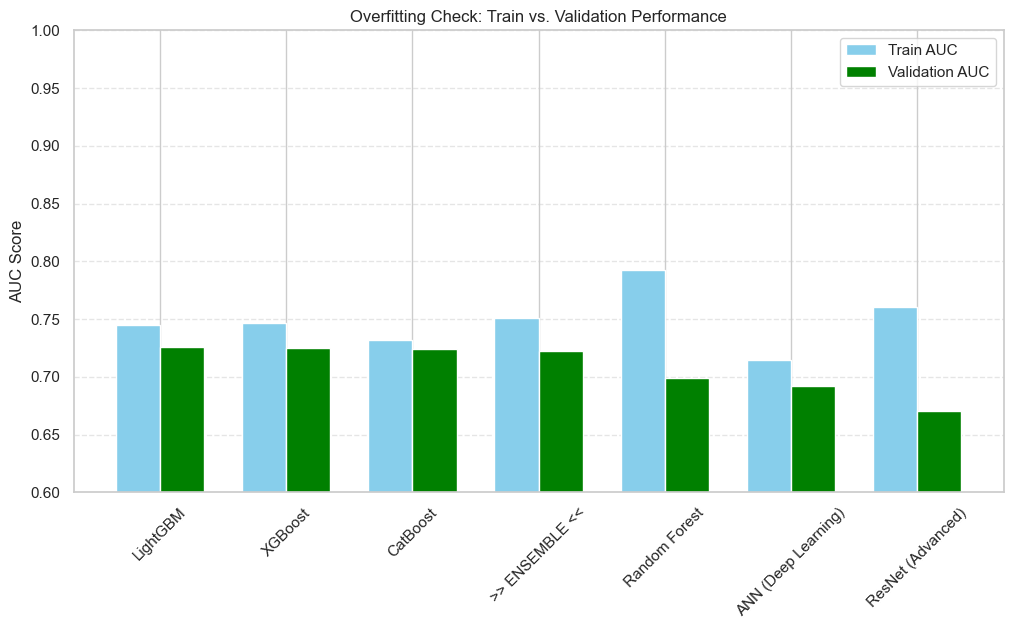

In [14]:
# 5. Plot Comparison (Val AUC vs Train AUC)
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['Train AUC'], width, label='Train AUC', color='skyblue')
plt.bar(x + width/2, results_df['Val AUC'], width, label='Validation AUC', color='green')

plt.ylabel('AUC Score')
plt.title('Overfitting Check: Train vs. Validation Performance')
plt.xticks(x, results_df['Model'], rotation=45)
plt.ylim(0.6, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

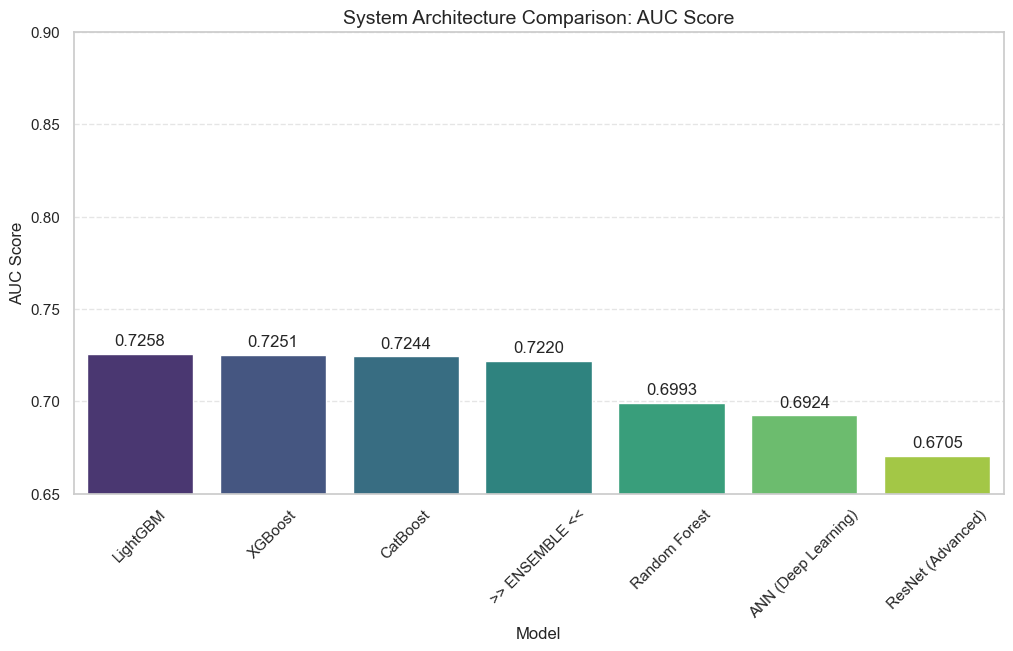

In [15]:
# Comparison Bar Plot
plt.figure(figsize=(12, 6))

barplot = sns.barplot(data=results_df, x='Model', y='Val AUC', palette='viridis')

plt.ylim(0.65, 0.90)  
plt.title('System Architecture Comparison: AUC Score', fontsize=14)
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.4f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')
plt.show()

### Prediction Confidence Analysis
We analyze the distribution of predicted probabilities.
* **Histogram:** Shows the frequency of probability scores.
* **KDE Plot:** Separates the confidence distributions for Healthy vs. Diabetic patients. A good model shows clear separation between the two peaks.

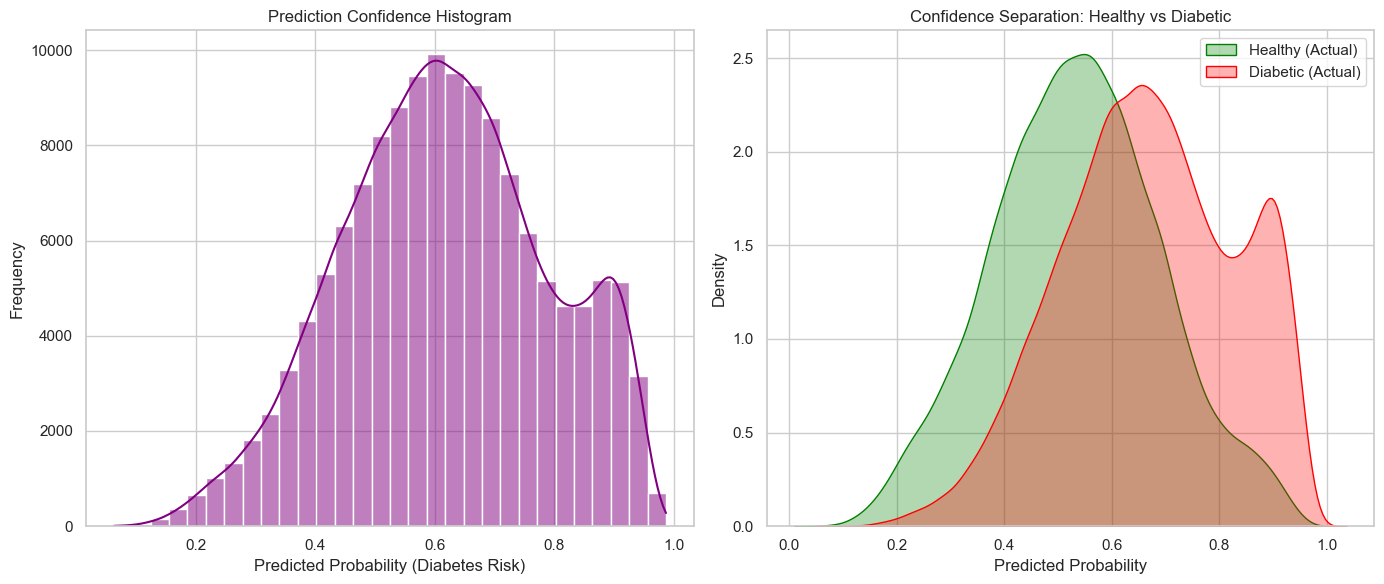

In [16]:
# --- Confidence Distribution Plots ---

plt.figure(figsize=(14, 6))

# Histogram of Predicted Probabilities
plt.subplot(1, 2, 1)
sns.histplot(ensemble_pred, bins=30, kde=True, color='purple')
plt.title('Prediction Confidence Histogram')
plt.xlabel('Predicted Probability (Diabetes Risk)')
plt.ylabel('Frequency')

# KDE Plot (Separation)
plt.subplot(1, 2, 2)
sns.kdeplot(ensemble_pred[y_val==0], label='Healthy (Actual)', fill=True, color='green', alpha=0.3)
sns.kdeplot(ensemble_pred[y_val==1], label='Diabetic (Actual)', fill=True, color='red', alpha=0.3)
plt.title('Confidence Separation: Healthy vs Diabetic')
plt.xlabel('Predicted Probability')
plt.legend()

plt.tight_layout()
plt.show()

### Advanced Explainability (SHAP)
Going beyond simple feature importance, we use **SHAP (SHapley Additive exPlanations)** values to understand the impact of each feature on individual predictions. This helps explain *why* the model classifies a patient as high-risk.

Generating SHAP Explanations (This may take a moment)...


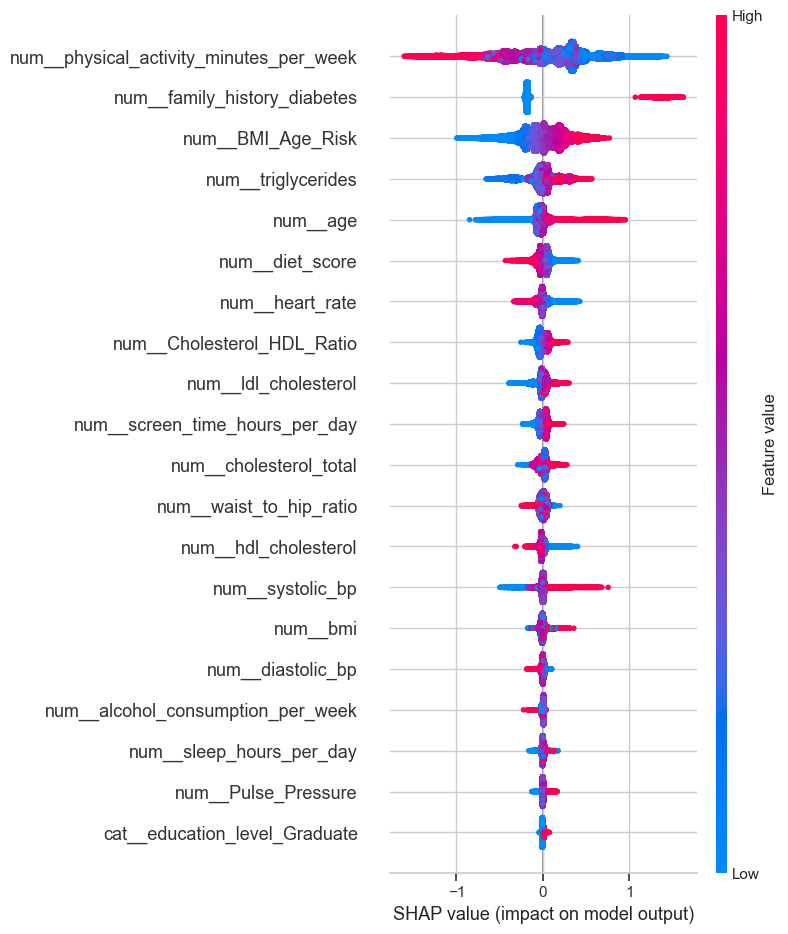

In [17]:
# --- SHAP Value Analysis ---
print("Generating SHAP Explanations (This may take a moment)...")


preprocessor_step = xgb_model.named_steps['preprocessor']
X_val_processed = preprocessor_step.transform(X_val)
feature_names = preprocessor_step.get_feature_names_out()

xgb_classifier = xgb_model.named_steps['classifier']
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_val_processed)

# SHAP Summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, show=True)

### System Comparison (ROC Curves)
To validate our architecture, we plot the **Receiver Operating Characteristic (ROC) Curves** for all individual models against the final Ensemble.
The **Black Line (Ensemble)** should be the outermost curve, indicating that the combined system outperforms any single individual model.

In [18]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))

# Calculate ROC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_val, probs_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, probs_xgb)
fpr_cat, tpr_cat, _ = roc_curve(y_val, probs_cat)
fpr_ann, tpr_ann, _ = roc_curve(y_val, probs_ann)
fpr_res, tpr_res, _ = roc_curve(y_val, probs_resnet)
fpr_ens, tpr_ens, _ = roc_curve(y_val, ensemble_pred)

<Figure size 1200x800 with 0 Axes>

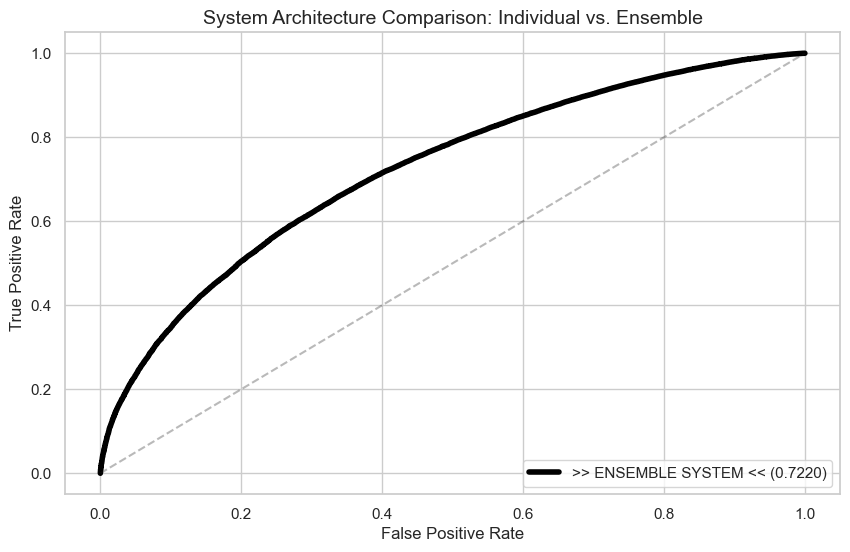

In [19]:
# Plot Ensemble (Highlight)
plt.plot(fpr_ens, tpr_ens, label=f'>> ENSEMBLE SYSTEM << ({auc(fpr_ens, tpr_ens):.4f})', linewidth=4, color='black')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.title('System Architecture Comparison: Individual vs. Ensemble', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

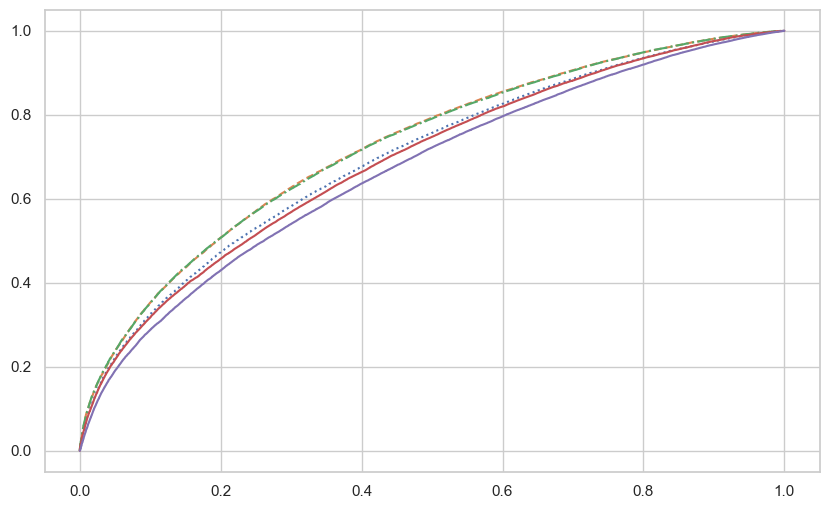

In [20]:
# Plot Individual Models
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ({auc(fpr_rf, tpr_rf):.4f})', linestyle=':')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ({auc(fpr_xgb, tpr_xgb):.4f})', linestyle='--')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost ({auc(fpr_cat, tpr_cat):.4f})', linestyle='-.')
plt.plot(fpr_ann, tpr_ann, label=f'ANN ({auc(fpr_ann, tpr_ann):.4f})')
plt.plot(fpr_res, tpr_res, label=f'ResNet ({auc(fpr_res, tpr_res):.4f})')

### Classification Metrics
We analyze the confusion matrix to understand the balance between **Precision** (Accuracy of positive predictions) and **Recall** (Ability to find all positive cases). This is critical in medical diagnosis to minimize missed diagnoses (False Negatives).


=== Final Classification Report ===
              precision    recall  f1-score   support

         0.0       0.61      0.42      0.50     52739
         1.0       0.70      0.84      0.77     87261

    accuracy                           0.68    140000
   macro avg       0.66      0.63      0.63    140000
weighted avg       0.67      0.68      0.66    140000



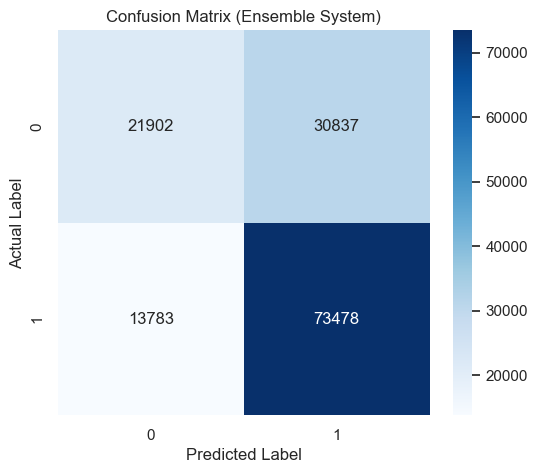

In [21]:
y_pred_binary = (ensemble_pred > 0.5).astype(int)

print("\n=== Final Classification Report ===")
print(classification_report(y_val, y_pred_binary))

# Plot Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Ensemble System)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Feature Importance Analysis
Understanding *why* the model makes a prediction is as important as the prediction itself. We visualize the **Top 15 Features** that contribute most to the diabetes risk, utilizing the XGBoost component of our system.

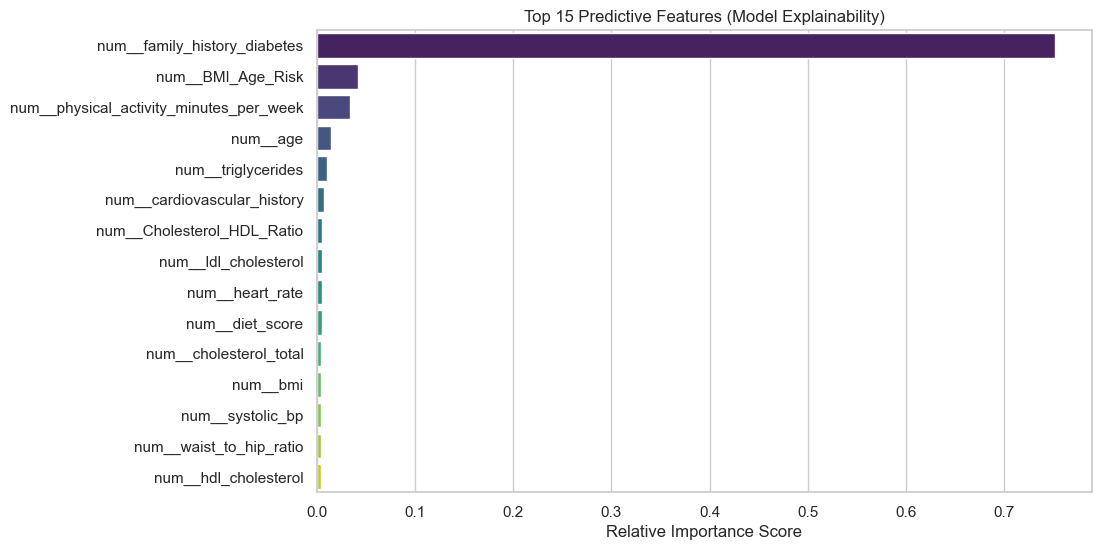

In [22]:
plt.figure(figsize=(10, 6))

# Extract importances from the XGBoost pipeline
importances = xgb_model.named_steps['classifier'].feature_importances_
feat_names = xgb_model.named_steps['preprocessor'].get_feature_names_out()

indices = np.argsort(importances)[::-1][:15]
sns.barplot(x=importances[indices], y=feat_names[indices], palette='viridis')

plt.title('Top 15 Predictive Features (Model Explainability)')
plt.xlabel('Relative Importance Score')
plt.show()

## Final Submission Generation
We apply the trained ensemble logic to the Test Set to generate the final prediction CSV for Kaggle. All models are also saved for potential deployment.

In [23]:
import os
import joblib
import pandas as pd
import numpy as np

os.makedirs('Submissions', exist_ok=True)
os.makedirs('Models', exist_ok=True)

print("🚀 Starting Final Submission & Saving Process...")

print("Step 1: Generating predictions for all 6 models...")

t_xgb  = xgb_model.predict_proba(X_test_sub)[:, 1]
t_cat  = cat_model.predict_proba(X_test_sub)[:, 1]
t_lgbm = lgbm_model.predict_proba(X_test_sub)[:, 1]
t_rf   = rf_model.predict_proba(X_test_sub)[:, 1]


X_test_ann = ann_preprocessor.transform(X_test_sub)
t_ann = ann_model.predict(X_test_ann, verbose=0).flatten()
t_res = resnet_model.predict(X_test_ann, verbose=0).flatten()

print("   -> Predictions Generated Successfully.")

print("\nStep 2: Saving individual CSV files to 'Submissions/' folder...")

submission['diagnosed_diabetes'] = t_xgb
submission.to_csv('Submissions/submission_xgb.csv', index=False)

submission['diagnosed_diabetes'] = t_cat
submission.to_csv('Submissions/submission_catboost.csv', index=False)

submission['diagnosed_diabetes'] = t_lgbm
submission.to_csv('Submissions/submission_lgbm.csv', index=False)

submission['diagnosed_diabetes'] = t_rf
submission.to_csv('Submissions/submission_rf.csv', index=False)

submission['diagnosed_diabetes'] = t_ann
submission.to_csv('Submissions/submission_ann.csv', index=False)

submission['diagnosed_diabetes'] = t_res
submission.to_csv('Submissions/submission_resnet.csv', index=False)

print("   -> SUCCESS: All 6 individual model files saved!")

print("\nStep 3: Calculating & Saving Final Ensemble...")


final_test_preds = (0.30 * t_xgb) + (0.30 * t_cat) + (0.15 * t_lgbm) + \
                   (0.05 * t_rf) + (0.10 * t_ann) + (0.10 * t_res)

submission['diagnosed_diabetes'] = final_test_preds
submission.to_csv('Submissions/submission_final.csv', index=False)
print("   -> SUCCESS: Final Ensemble 'submission_final.csv' created! (Use this for Kaggle)")

print("\nStep 4: Saving Trained Models & Preprocessor to 'Models/' folder...")

joblib.dump(xgb_model, 'Models/xgb_model.pkl')
joblib.dump(cat_model, 'Models/cat_model.pkl')
joblib.dump(lgbm_model, 'Models/lgbm_model.pkl')
joblib.dump(rf_model, 'Models/rf_model.pkl')

ann_model.save('Models/ann_model.keras')
resnet_model.save('Models/resnet_model.keras')

try:
    joblib.dump(ann_preprocessor, 'Models/preprocessor.pkl') 
    print("   -> SUCCESS: 'preprocessor.pkl' saved!")
except NameError:
    print("   -> ERROR: 'ann_preprocessor' variable not found. Run the preprocessing cell first.")

print("\n ALL DONE: Everything is saved and ready!")

🚀 Starting Final Submission & Saving Process...
Step 1: Generating predictions for all 6 models...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.5s finished


   -> Predictions Generated Successfully.

Step 2: Saving individual CSV files to 'Submissions/' folder...
   -> SUCCESS: All 6 individual model files saved!

Step 3: Calculating & Saving Final Ensemble...
   -> SUCCESS: Final Ensemble 'submission_final.csv' created! (Use this for Kaggle)

Step 4: Saving Trained Models & Preprocessor to 'Models/' folder...
   -> SUCCESS: 'preprocessor.pkl' saved!

 ALL DONE: Everything is saved and ready!
